In [1]:
import os
from os.path import join, dirname
from datetime import date
from glob import glob

import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc
import seaborn as sns
import plotly as py
import plotly.express as px

import random
import nilearn

from tqdm import tqdm

import urllib

import torchvision
from torchvision import transforms
from torchvision import models, utils
import cv2
import argparse

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.autograd import Variable as V
from PIL import Image
from decord import VideoReader
from decord import cpu

## import mydef as my Class correction for projects
import mydef

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


In [3]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
# subj = random.sample(GA.list_subj, k=1)[0]
subj = '01'
stage = 'late_practice'
run = random.sample(['r01', 'r02', 'r03'], k=1)[0]
print(subj, stage, run)

01 late_practice r03


In [6]:
gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')

# Loading behavioural data

In [7]:
suffix = 'fmri' if 'early' in stage else ('refmri' if 'late' in stage else 'invalid')
data = scipy.io.loadmat(GA.dir_behav+'/GA%s-%s.mat'%(subj,suffix))

---

In [7]:
data['A'].shape

(14, 2)

In [9]:
data['allData'][:,28800:].shape

(14, 203700)

In [12]:
temp = np.matmul(data['A'].T,data['allData'][:,28800:])

In [20]:
temp

array([[ 0.67551816,  0.67541474,  0.6747625 , ...,  1.4712502 ,
         1.4667603 ,  1.4668608 ],
       [-0.6419686 , -0.6465313 , -0.64649916, ..., -0.36044824,
        -0.3576762 , -0.35063392]], dtype=float32)

In [19]:
data['allXY']

array([[ -13.27482663,    5.17862281,   25.58709472, ..., -138.05887163,
        -138.71128142, -139.78531301],
       [ 141.87375784,   45.74518606,  -65.94149798, ...,  151.06984198,
         150.23626149,  149.1441679 ]])

In [21]:
beta = np.matmul(np.matmul(data['allXY'],temp.T), np.linalg.inv(np.matmul(temp, temp.T)))

In [22]:
beta

array([[ -92.56682596, -231.85314614],
       [ -20.48670285,  -51.52851718]])

In [23]:
data['allXY'] - np.matmul(beta, temp)

array([[-99.5866966 , -82.20069065, -61.84514705, ..., -85.44097135,
        -85.86629219, -85.29824461],
       [122.63320711,  26.26740879, -85.43098232, ..., 162.63754377,
        161.85481882, 161.12766271]])

---

# Loading fMRI data

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [8]:
dir_pb02 = '/mnt/sda2/GA/fmri_data/preproc_data/'

1. pb02

In [6]:
img = nilearn.image.load_img(
    join(dir_pb02,'%s%s'%(gg, subj),'epi.volreg.%s%s.%s.nii.gz'%(gg,subj,run))
)

2. 3dLSS

In [9]:
img = nilearn.image.load_img(
    join(GA.dir_fmri, 'preproc_data', subj,'betasLSS.%s%s.%s.nii.gz'%(gg, subj, run))
)
img.shape

(72, 85, 72, 97)

### ROIs

0. Full mask

1. Localizers

In [ ]:
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = nilearn.image.load_img(path)
GA.roi_imgs

In [ ]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']
temp = {}
for key in key_list:
    temp[key] = GA.roi_imgs[key]
GA.roi_imgs = temp
GA.roi_imgs

2. Yeo 1 network

In [10]:
GA.load_fan()

dt = pd.DataFrame()
## yeo_17network == 1
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]
GA.roi_imgs

{'FuG_L_3_2': <nibabel.nifti1.Nifti1Image at 0x7fe0cda041c0>,
 'FuG_R_3_2': <nibabel.nifti1.Nifti1Image at 0x7fe0cda04d60>,
 'MVOcC_L_5_1': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9c85b0>,
 'MVOcC_R_5_1': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9c2a30>,
 'MVOcC_L_5_3': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9c2760>,
 'MVOcC_R_5_3': <nibabel.nifti1.Nifti1Image at 0x7fe0cea1cb20>,
 'MVOcC_R_5_4': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9ccc70>,
 'LOcC_L_4_1': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9cc2e0>,
 'LOcC_R_4_1': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9c8e50>,
 'LOcC_L_4_3': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9d2ac0>,
 'LOcC_R_4_3': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9d8be0>,
 'LOcC_L_4_4': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9d2520>,
 'LOcC_R_4_4': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9d2370>,
 'LOcC_L_2_2': <nibabel.nifti1.Nifti1Image at 0x7fe0cd9ccfd0>}

Masking

In [13]:
roi = 'FuG_L_3_2'

In [14]:
masked_img = GA.fast_masking(img=img, roi=GA.roi_imgs[roi])
masked_img.shape

(97, 333)

Figure

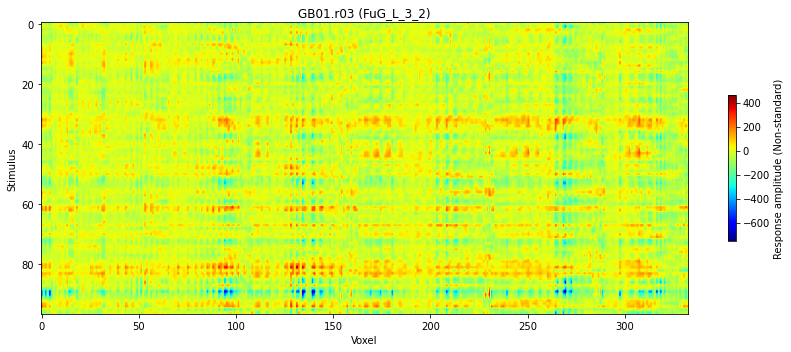

In [15]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s%s.%s (%s)'%(gg, subj, run, roi))
heatmap = ax.imshow(masked_img, aspect="auto",cmap='jet')
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Non-standard)")
f.tight_layout()

The beta values were z-scored across stimulus (features).

In [16]:
masked_img = StandardScaler().fit_transform(masked_img)

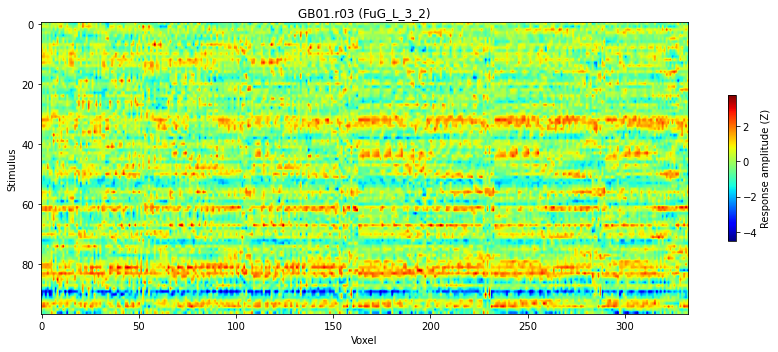

In [17]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s%s.%s (%s)'%(gg, subj, run, roi))
heatmap = ax.imshow(masked_img, aspect="auto",cmap='jet')
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

# Loading videos

In [17]:
list_video = glob(join(GA.dir_work,'videos','*.mp4'))

In [18]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run))
           , 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>.3
""" % data_url)

In [19]:
def sample_video_from_mp4(vpath, num_frames=15):
    """This function takes a mp4 video vpath as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    vpath : str
        path to mp4 video vpath
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(vpath, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images, num_frames

---

In [130]:
video, num_frames = sample_video_from_mp4(vpath=join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run)), num_frames=int(29100*.25))

/tmp/ipykernel_2213212/683694106.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)


In [131]:
video

[<PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542E20>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542B50>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542BB0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542D30>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542AC0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542A90>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542FD0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542B20>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542C10>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542C40>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542BE0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542B80>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542C70>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542CA0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F7D04542EE0>,
 <PIL.Imag

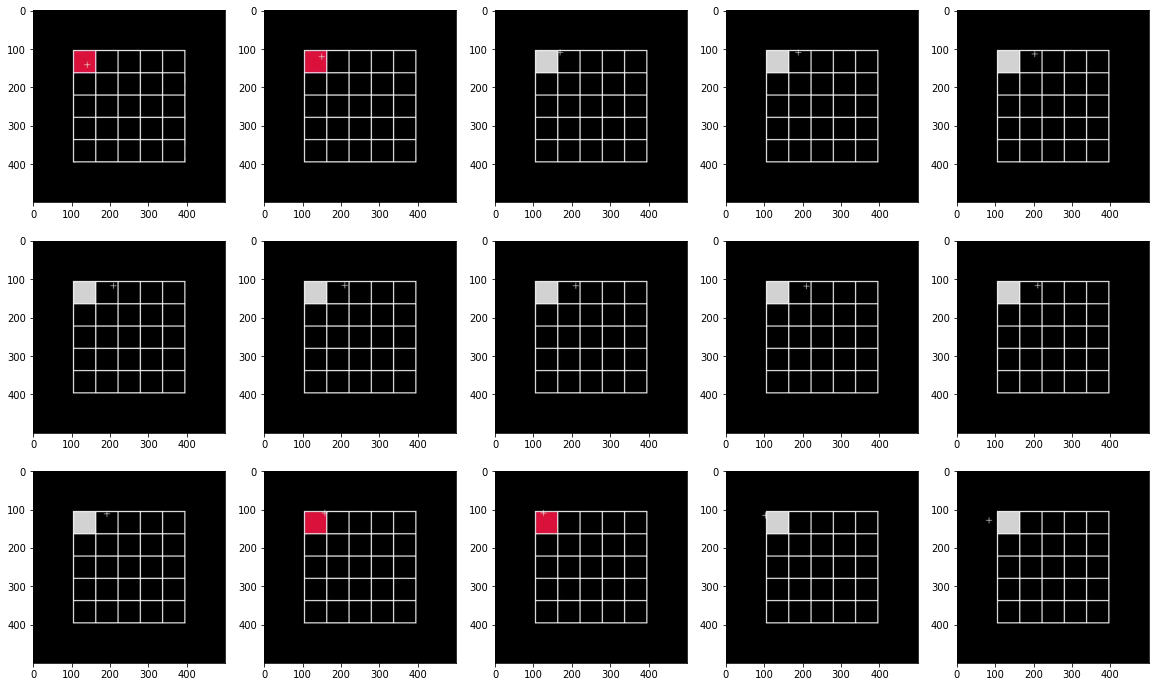

In [78]:
fig = plt.figure(figsize=(20, 12))

for i, img in enumerate(video[:15]):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(img)

In [79]:
resize_normalize = transforms.Compose([
            transforms.Resize((224,224))
            , transforms.ToTensor()
            , transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [80]:
input_img = V(resize_normalize(video[0]).unsqueeze(0))
input_img = input_img.to(device)

---

# Vision model definition

In [20]:
_models = {'r2d':models.resnet18(pretrained=True)
          , 'r3d':models.video.r3d_18(pretrained=True)
          , 'vgg16':models.vgg16(pretrained=True)}

In [57]:
from torchsummary import summary

# summary(model=models['r2d'].cpu(), input_size=(3, 224, 224), device='cpu')
# summary(model=models['r3d'].cpu(), input_size=(3, 97, 224, 224), device='cpu')
summary(model=_models['vgg16'].cpu(), input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# for param in model.parameters():
#     print(param.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])


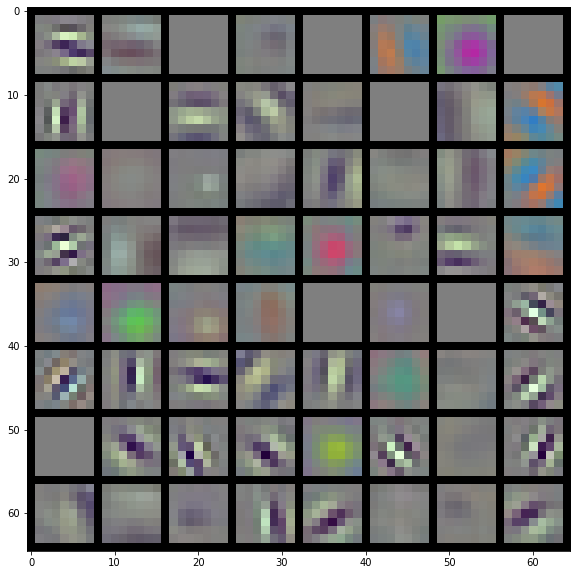

In [26]:
# def show(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# # visualize the filters of the first CNN layer
# for w in models['r2d'].parameters():
#     w = w.data.cpu()
#     print(w.shape)
#     break

# # normalize weights
# min_w = torch.min(w)
# w1 = (-1/(2 * min_w)) * w + 0.5

# # make grid to display it
# grid_size = len(w1)
# x_grid = [w1[i] for i in range(grid_size)]
# x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

# plt.figure(figsize=(10, 10))
# show(x_grid)

In [21]:
def vgg16(_input, device=device):
    net = _models['vgg16'].to(device)
    outs = {}
    outs['1'] = net.features[:2](_input.to(device))
    outs['2'] = net.features[2:5](outs['1'])
    outs['3'] = net.features[5:7](outs['2'])
    outs['4'] = net.features[7:10](outs['3'])
    outs['5'] = net.features[10:12](outs['4'])
    outs['6'] = net.features[12:14](outs['5'])
    outs['7'] = net.features[14:17](outs['6'])
    outs['8'] = net.features[17:19](outs['7'])
    outs['9'] = net.features[19:21](outs['8'])
    outs['10'] = net.features[21:24](outs['9'])
    outs['11'] = net.features[24:26](outs['10'])
    outs['12'] = net.features[26:28](outs['11'])
    outs['13'] = net.features[28:](outs['12'])
    
    return outs

---

In [22]:
resize_normalize = transforms.Compose([
            transforms.Resize((224,224))
            , transforms.ToTensor()
            , transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [20]:
input_img = V(resize_normalize(video[0]).unsqueeze(0))
input_img = input_img.to(device)

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/torch/cuda/__init__.py:106: UserWarning: 
GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [58]:
## model test
model = _models['vgg16'].to('cpu')
# value = torch.Tensor(1,3,224,224).to('cpu')
value = input_img.to('cpu')
print('input.shape =', value.shape)
out = model(value)
print('output.shape =', out.shape)

input.shape = torch.Size([1, 3, 224, 224])
output.shape = torch.Size([1, 1000])


In [84]:
for name, layer in enumerate(model.named_children()):
    print(name, layer)

0 ('features', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256,

In [115]:
features = vgg16(value, device='cpu')
features.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])

---

# Feature extraction

In [69]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def get_activations_and_save(model, subj, stage, run, dir_activation, ITI=5, device=device):

    gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
    model.to(device)
    
    resize_normalize = transforms.Compose([
            transforms.Resize((224,224))
            , transforms.ToTensor()
            , transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    ## a number of total frames: 29100
    total_frame = int(60*5*97)
    ## down sampling: 60Hz * 0.25
    down_sample = 0.25
    
    output_dir = join(dir_activation, subj)
    os.makedirs(output_dir, exist_ok=True)

    video, num_frames = sample_video_from_mp4(
        vpath=join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run))
        , num_frames=int(total_frame*down_sample)
    )
    trial = 0
    for frame, img in enumerate(tqdm(video)):
        ## is it the 1st frame of each trial?
        is_1st = frame % (down_sample*60*ITI) == 0
        ## is it the last frame of each trial?
        is_last = (frame+1) % (down_sample*60*ITI) == 0

        ## at the 1st frame of a trial
        if is_1st:
            trial += 1
            activations = []

#         if trial != 84:
#             continue
            
        input_img = V(resize_normalize(img).unsqueeze(0))
        input_img = input_img.to(device)

        out = vgg16(input_img, device=device)
        for i, feature in out.items():
            if is_1st:
                activations.append(feature.data.cpu().numpy().ravel())
            else:
                activations[int(i)-1] =  activations[int(i)-1] + feature.data.cpu().numpy().ravel()

        ## at the end of a trial
        if is_last:
            for layer in range(len(activations)):
                avg_layer_activation = activations[layer]/float(down_sample*60*ITI)
                np.save(
                    join(output_dir,"%s.%s.trial%02d.layer%02d.npy"%(stage,run,trial,layer+1))
                    , avg_layer_activation
                )


In [76]:
model = _models['vgg16'].to(device)
# next(model.parameters()).is_cuda

In [77]:
# print('Total Number of Videos: ', len(list_video))

# # get and save activations
dir_activation = join(GA.dir_work,'results','activations','vgg16')
os.makedirs(dir_activation, exist_ok=True)
print("-------------Saving activations ----------------------------")
for run in ['r01', 'r02', 'r03']:
    print(run)
    get_activations_and_save(
        model=model, subj='01', stage='late_practice', run=run
        , dir_activation=dir_activation, device='cpu')

-------------Saving activations ----------------------------
r01


/tmp/ipykernel_1434651/683694106.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
100%|██████████| 7275/7275 [01:04<00:00, 113.64it/s]  


# PCA

In [30]:
layer = 'layer01'

In [24]:
runs = np.array(['r01', 'r02', 'r03'])
loo = LeaveOneOut()
for idx_train, idx_test in loo.split(runs):
    print("%s %s" % (runs[idx_train], runs[idx_test]))

['r02' 'r03'] ['r01']
['r01' 'r03'] ['r02']
['r01' 'r02'] ['r03']


In [67]:
def do_PCA_and_save(dir_activation, stage, layer, dir_save, n_components=97):

    os.makedirs(dir_save, exist_ok=True)
    runs = ['r01', 'r02', 'r03'] if 'practice' in stage else (['r04', 'r05', 'r06'] if 'unpractice' in stage else 'invalid')
    runs = np.array(runs)

    loo = LeaveOneOut()
    for idx_train, idx_test in loo.split(runs):
        ## test
        activations_file_list = glob(join(dir_activation,'%s.%s.*.%s.npy'%(stage,runs[idx_test][0],layer)))
        activations_file_list.sort()
        
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp

        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=seed)
        x = ipca.fit_transform(x)
        np.save(join(dir_save,"%s.%s"%(runs[idx_test][0],layer)), x)
        
        ## train
        activations_file_list = []
        for run in runs[idx_train]:
            activations_file_list.append(glob(join(dir_activation,'%s.%s.*.%s.npy'%(stage,run,layer))))
        activations_file_list = np.concatenate(activations_file_list)
        activations_file_list.sort()
        
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp

        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=seed)
        x = ipca.fit_transform(x)
        np.save(join(dir_save,"%sc.%s"%(runs[idx_test][0],layer)), x)

In [72]:
# def do_PCA_and_save(dir_activation, run, layer, dir_save, n_components=97):

#     os.makedirs(dir_save, exist_ok=True)
    
#     activations_file_list = glob(join(dir_activation,'*%s.*%s.npy'%(run,layer)))
#     activations_file_list.sort()
#     feature_dim = np.load(activations_file_list[0])
#     x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
#     for i,activation_file in enumerate(activations_file_list):
#         temp = np.load(activation_file)
#         x[i,:] = temp

#     x = StandardScaler().fit_transform(x)

#     ipca = PCA(n_components=n_components,random_state=seed)

#     x = ipca.fit_transform(x)

#     np.save(join(dir_save,"%s.%s"%(run,layer)), x)

In [43]:
layers = ['layer%02d'%(i+1) for i in range(13)]

In [39]:
# _list = np.array(np.meshgrid(['r01', 'r02', 'r03'], layers)).T.reshape(-1, 2)
# _list

array([['r01', 'layer01'],
       ['r01', 'layer02'],
       ['r01', 'layer03'],
       ['r01', 'layer04'],
       ['r01', 'layer05'],
       ['r01', 'layer06'],
       ['r01', 'layer07'],
       ['r01', 'layer08'],
       ['r01', 'layer09'],
       ['r01', 'layer10'],
       ['r01', 'layer11'],
       ['r01', 'layer12'],
       ['r01', 'layer13'],
       ['r02', 'layer01'],
       ['r02', 'layer02'],
       ['r02', 'layer03'],
       ['r02', 'layer04'],
       ['r02', 'layer05'],
       ['r02', 'layer06'],
       ['r02', 'layer07'],
       ['r02', 'layer08'],
       ['r02', 'layer09'],
       ['r02', 'layer10'],
       ['r02', 'layer11'],
       ['r02', 'layer12'],
       ['r02', 'layer13'],
       ['r03', 'layer01'],
       ['r03', 'layer02'],
       ['r03', 'layer03'],
       ['r03', 'layer04'],
       ['r03', 'layer05'],
       ['r03', 'layer06'],
       ['r03', 'layer07'],
       ['r03', 'layer08'],
       ['r03', 'layer09'],
       ['r03', 'layer10'],
       ['r03', 'layer11'],
 

In [ ]:
# preprocessing using PCA and save
dir_activation = join(GA.dir_work,'results','activations','vgg16', subj)
dir_save = join(GA.dir_work,'results','activations','vgg16','pca', subj)

print("-------------performing  PCA----------ㅓ------------------")
for layer in tqdm(layers[2:]):
    do_PCA_and_save(dir_activation, stage, layer, dir_save)

-------------performing  PCA----------------------------


 36%|███▋      | 4/11 [2:16:36<4:09:11, 2135.92s/it]

In [ ]:
do_PCA_and_save(dir_activation, stage, 'layer02', dir_save)

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 

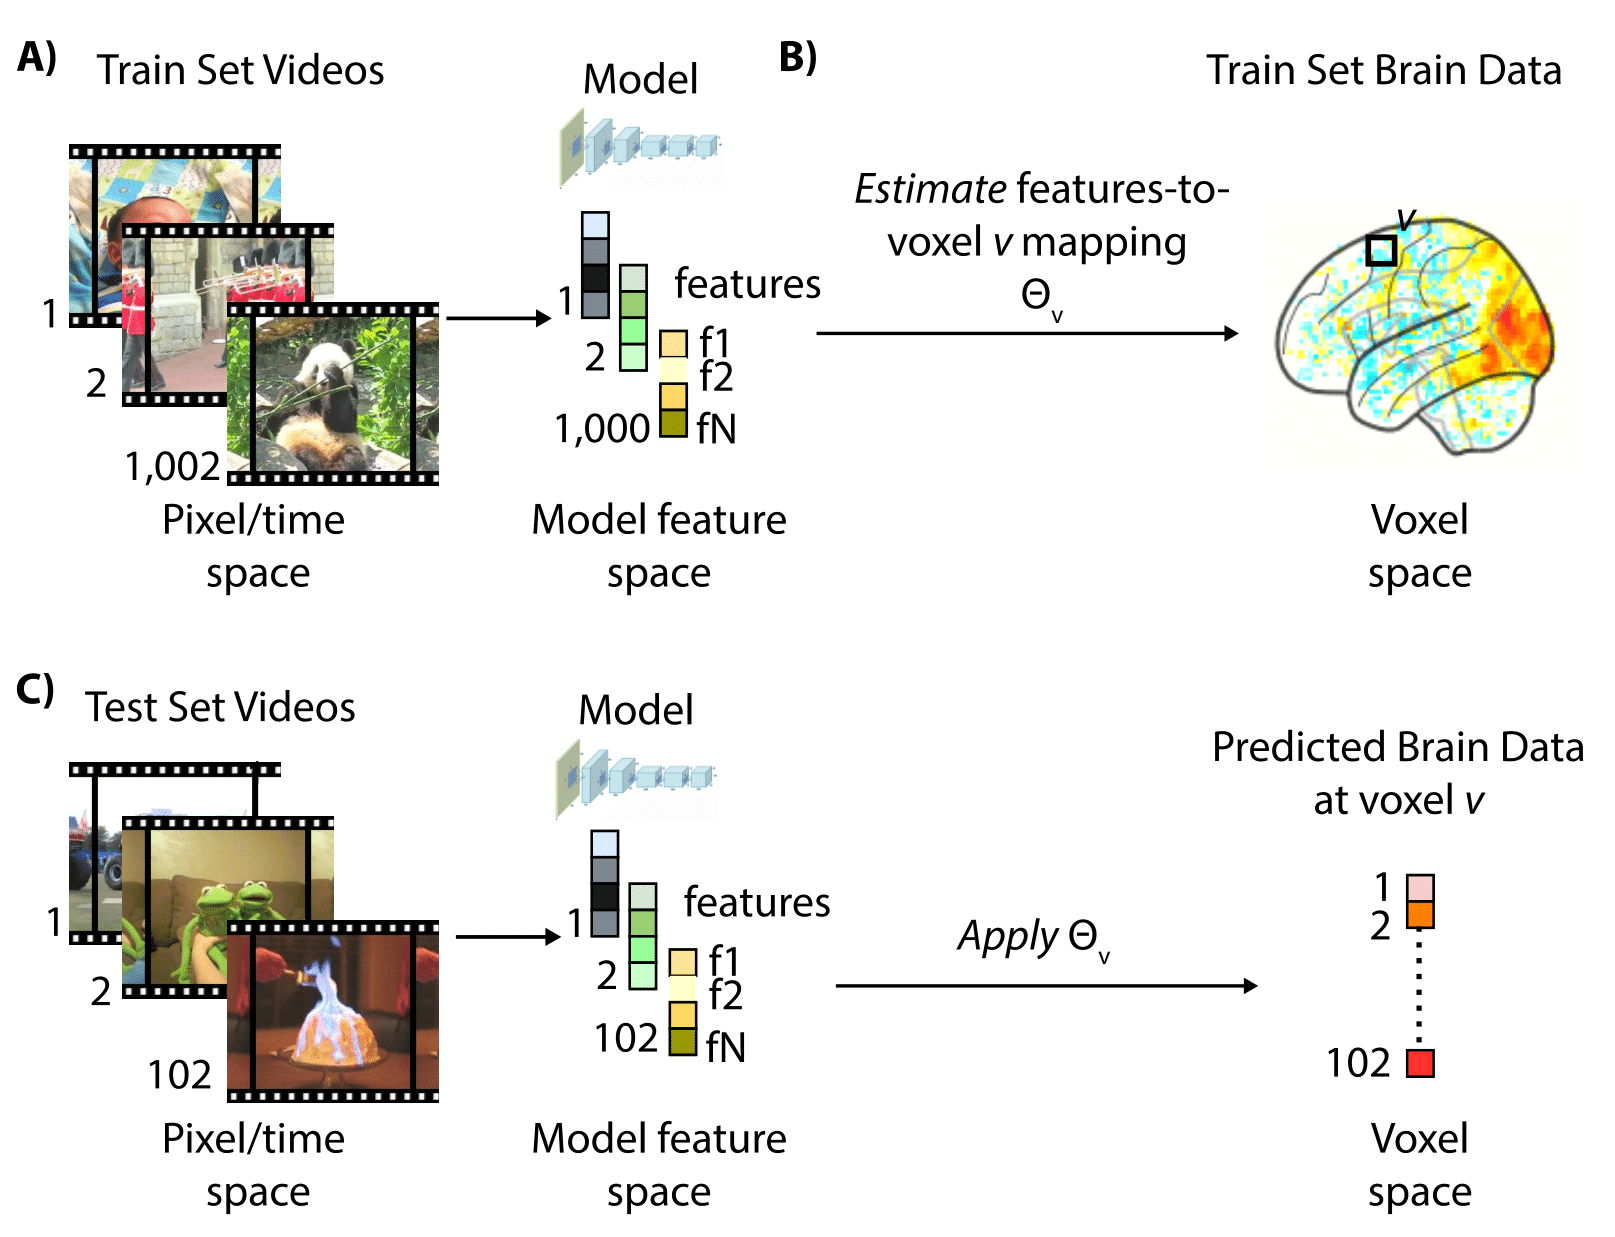

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

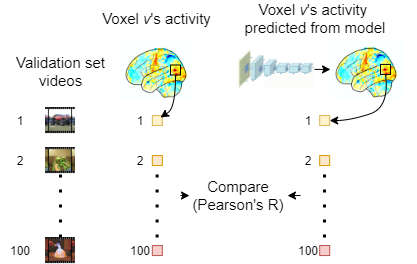

---

In [18]:
def get_activations(dir_pca, run, layer):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    dir_pca : str
        Path to PCA processed Neural Network features
    layer : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    """

    train_file = join(dir_pca,'%s.%s.npy'%(run,layer))
    train_activations = np.load(train_file)
    
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)

    return train_activations

In [19]:
class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def _reshape_x(self,X):
        ## 열벡터로 변환
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ## [x] -> [1 x]
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)
        
    def fit(self,X,y):
        ## 행벡터 인가?
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)
        ## X = [1 X] -> X.shape = (nvideo, 100+1)
        X = self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        ## y.shapy = (nvideo, nvoxel)
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        ## XtX * betas = XtX
        ## ()
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky
        
    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
            ## -> entry : 열벡터
        entry = self._concatenate_ones(entry)
        ## -> entry : [1 entry]
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        ## prediction = [1 entry] * betas = (N * 2) * ()
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        
        return prediction

def predict_fmri_fast(train_activations, test_activations, train_fmri, use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions (#train_vids) x (#pca_components)
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions (#test_vids) x (#pca_components)
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions (#train_vids) x (#voxels)
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions (#test_vids) x (#voxels)
        containing predicted fMRI responses to test videos .
    """
    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations, train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    
    return fmri_pred_test

In [ ]:
for layer in layers:
    train_activations = join(GA.dir_work,'results','activations','vgg16','pca', subj, '%s.%s.npy'%(run, layer))
    test_activations = 
    fmri_pred_test = predict_fmri_fast(train_activations, test_activations)

---

In [80]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    ## 베셀 보정 (n-1) 한 Pearson correlation
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

---

In [77]:
from scipy.stats import pearsonr

a = np.random.rand(10)
b = np.random.rand(10)

print(pearsonr(a,b))

print(vectorized_correlation(a,b))

(0.1501648836099866, 0.678821823566329)
[0.16684986]


---

In [32]:
def perform_encoding(pca_dir, fmri_dir, results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
    if torch.cuda.is_available():
        use_gpu = True
    else:
        use_gpu = False

    ###### Load activations ##############
    train_activations, test_activations = get_activations(pca_dir, layer)
    ######################################

    ##### Load fMRI data #################
    fmri_train_all, voxel_mask = get_fmri(os.path.join(fmri_dir, track, subj),ROI)

    num_voxels = fmri_train_all.shape[1]
    ######################################


    #### Creating data splits ###############
    if mode == 'val':
        # Here as an example we use first 900 videos as training and rest of the videos as validation
        test_activations = train_activations[900:,:]
        train_activations = train_activations[:900,:]
        fmri_train = fmri_train_all[:900,:]
        fmri_test = fmri_train_all[900:,:]
        pred_fmri = np.zeros_like(fmri_test)
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
    else:
        fmri_train = fmri_train_all
        num_test_videos = 102
        pred_fmri = np.zeros((num_test_videos,num_voxels))
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
    ######################################

    ######## Performing regression ################
    iter = 0

    while iter < num_voxels-batch_size:
        pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
        iter = iter+batch_size
    pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
    if mode == 'val':
        score = vectorized_correlation(fmri_test, pred_fmri)
        print("----------------------------------------------------------------------------")
        print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
        ################################################

        nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
        ######## Result visualization ################
        if track == "full_track" and visualize_results:
            visual_mask_3D = np.zeros((78,93,71))
            visual_mask_3D[voxel_mask==1] = score
            brain_mask = '/content/example.nii'
            saveasnii(brain_mask, nii_save_path, visual_mask_3D)
            plotting.plot_glass_brain(nii_save_path, plot_abs=False,
                              title = 'Correlation for ' + sub + ' and ' + layer,
                              display_mode='lyr', colorbar=True,vmin=-1,vmax=1)

        ################################################

    np.save(pred_fmri_save_path, pred_fmri)


If you use the default parameters (sub04, EBA, layer_5) you should obtain a correlation of 0.219 between predicted and recorded fMRI responses on validation videos.

# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
# layer = 'layer_5'
model = 'alexnet'

dir_pca = os.path.join(dir_result, 'pca')
for layer in layers:
    for sub in subs:
        for ROI in ROIs:
            track = 'full_track' if ROI=='WB' else 'mini_track'
            print ("Starting ROI: ", ROI, "sub: ",sub)
            dir_output = os.path.join(dir_result, 'pred', model, layer, track, sub)
            os.makedirs(dir_output, exist_ok=True)

            perform_encoding(dir_pca, dir_fmri, dir_output, sub, layer, ROI=ROI, mode='test')
            print ("Completed ROI: ", ROI, "sub: ",sub)
            print("----------------------------------------------------------------------------")

Starting ROI:  WB sub:  sub01


---

In [29]:
subj = random.sample(list_subj, k=1)[0]
ROI = random.sample(list_ROI, k=1)[0]

track = 'full_track' if ROI=='WB' else 'mini_track'

layer = 'layer_5'
model = 'alexnet'

In [32]:
fmri_pred = np.load(os.path.join(dir_result, 'pred', model, layer, track, subj, '%s_test.npy'%ROI))

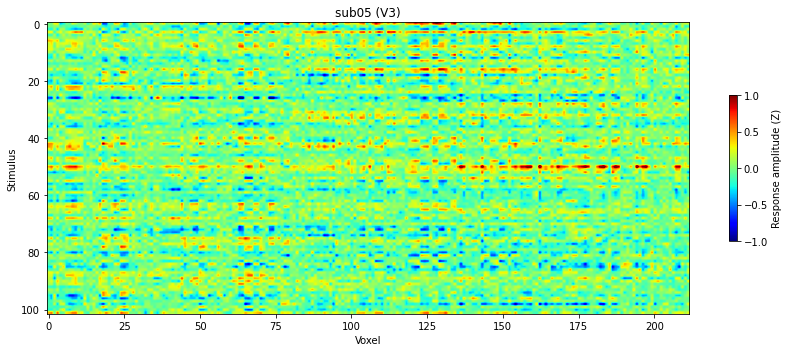

In [35]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s (%s)'%(subj,ROI))
heatmap = ax.imshow(fmri_pred, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()